In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install gdown

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Model
!gdown --id  1f6WhzP4bdgzy34HBZxlHGmM-Mg1wIGGI

Downloading...
From: https://drive.google.com/uc?id=1f6WhzP4bdgzy34HBZxlHGmM-Mg1wIGGI
To: D:\ProgProjekte\Python\EIPH_WSI\SDATA\Inference\RetinaNet-L0-61.p

0.00B [00:00, ?B/s]
6.29MB [00:00, 50.2MB/s]
15.2MB [00:00, 57.5MB/s]
27.3MB [00:00, 67.9MB/s]
39.3MB [00:00, 77.7MB/s]
51.4MB [00:00, 86.5MB/s]
53.8MB [00:00, 96.6MB/s]


In [5]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd

In [6]:
from fastai.callbacks.csv_logger import CSVLogger

In [7]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [8]:
model_file = "RetinaNet-L0-61.p"
experiment_name = "Equine-RetinaNet-L0-V2-FineTune"


model_information = torch.load(model_file, map_location='cpu') \
                    if torch.cuda.is_available() ==  False \
                    else torch.load(model_file)

model_weights = model_information['model']

In [9]:
srep_slides_train = list(set(["08_EIPH_574999 R Turnbull blue.svs", 
                              "22_EIPH_575216 Turnbull blue.svs", 
                              "28_EIPH_569948 L Turnbull blue.svs", 
                              "07_EIPH_574882 left lung Turnbull blue.svs", 
                              "08_EIPH_574999 R Turnbull blue.svs", 
                              "09_EIPH_563417 L Turnbull blue.svs", 
                              "14_EIPH_568381 Turnbull blue.svs", 
                              "28_EIPH_569948 L Turnbull blue.svs", 
                              "29_EIPH_566481 L Turnbull blue.svs",
                              
                              "01_EIPH_563479 Berliner Blau.svs", 
                              "02_EIPH_574162 berliner blau.svs",
                              "03_EIPH_566933 R Berliner Blau neu.svs",
                              "04_EIPH_567017 Berliner Blau.svs",
                              "05_EIPH_569923 Berliner Blau.svs", 
                              "20_EIPH_576150 berliner blau.svs", 
                              "01_EIPH_563479 Berliner Blau.svs", 
                              "02_EIPH_574162 berliner blau.svs", 
                              "03_EIPH_566933 R Berliner Blau neu.svs",
                              "04_EIPH_567017 Berliner Blau.svs", 
                              "05_EIPH_569923 Berliner Blau.svs",     
                              "26_EIPH_566482 L Berliner Blau.svs",
                              "27_EIPH_571557 berliner blau.svs",
                              "31_EIPH_568354 Berliner Blau.svs"]))

srep_slides_val = list(set(["11_EIPH_575697 Berliner Blau.svs", 
                            "20_EIPH_576150 berliner blau.svs", 
                            "22_EIPH_575216 Turnbull blue.svs"]))

In [10]:
annotations_path = Path("../Statistics/EIPH_Annotations.pkl")
annotations = pd.read_pickle(annotations_path)
annotations_train = annotations[annotations["image_name"].isin(srep_slides_train)]
annotations_val = annotations[annotations["image_name"].isin(srep_slides_val)]
annotations_train.head()

,id,image_id,image_set,species,image_name,image_type,grade,vector,unique_identifier,user_id,deleted,last_editor,data_set_name,version
100398,1421918,3518,245,equine,07_EIPH_574882 left lung Turnbull blue.svs,TurnbullBlue,0,"{'x1': 19619, 'x2': 19747, 'y1': 3009, 'y2': 3...",87e3870c-2316-4689-beaf-d2d6ddf22c28,1,True,1,SREP,SREP
100399,1421919,3518,245,equine,07_EIPH_574882 left lung Turnbull blue.svs,TurnbullBlue,0,"{'x1': 20116, 'x2': 20202, 'y1': 3309, 'y2': 3...",ff289b7a-2fce-4d37-9feb-74b592d842d9,1,True,1,SREP,SREP
100400,1421922,3518,245,equine,07_EIPH_574882 left lung Turnbull blue.svs,TurnbullBlue,0,"{'x1': 14193, 'x2': 14279, 'y1': 3885, 'y2': 3...",6ffcd9c4-1e54-4b9b-b593-4f2c9e85704d,1,True,1,SREP,SREP
100401,1421923,3518,245,equine,07_EIPH_574882 left lung Turnbull blue.svs,TurnbullBlue,0,"{'x1': 14271, 'x2': 14347, 'y1': 3767, 'y2': 3...",1c3cb4f8-fad5-4b13-8859-5b83f31e450a,1,True,1,SREP,SREP
100402,1421924,3518,245,equine,07_EIPH_574882 left lung Turnbull blue.svs,TurnbullBlue,0,"{'x1': 14782, 'x2': 14860, 'y1': 3853, 'y2': 3...",682b6be5-664a-4bd0-ae5a-12a7963a2dd4,1,True,1,SREP,SREP


In [11]:
annotations_val["grade"].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [12]:
slides_path = Path("D:/Datasets/EIPH WSI/Pferd")
files = {slide.name: slide for slide in slides_path.glob("*/*.svs")  if slide.name in srep_slides_train + srep_slides_val}
files

{'01_EIPH_563479 Berliner Blau.svs': WindowsPath('D:/Datasets/EIPH WSI/Pferd/Berliner Blau/01_EIPH_563479 Berliner Blau.svs'),
 '02_EIPH_574162 berliner blau.svs': WindowsPath('D:/Datasets/EIPH WSI/Pferd/Berliner Blau/02_EIPH_574162 berliner blau.svs'),
 '03_EIPH_566933 R Berliner Blau neu.svs': WindowsPath('D:/Datasets/EIPH WSI/Pferd/Berliner Blau/03_EIPH_566933 R Berliner Blau neu.svs'),
 '04_EIPH_567017 Berliner Blau.svs': WindowsPath('D:/Datasets/EIPH WSI/Pferd/Berliner Blau/04_EIPH_567017 Berliner Blau.svs'),
 '05_EIPH_569923 Berliner Blau.svs': WindowsPath('D:/Datasets/EIPH WSI/Pferd/Berliner Blau/05_EIPH_569923 Berliner Blau.svs'),
 '11_EIPH_575697 Berliner Blau.svs': WindowsPath('D:/Datasets/EIPH WSI/Pferd/Berliner Blau/11_EIPH_575697 Berliner Blau.svs'),
 '20_EIPH_576150 berliner blau.svs': WindowsPath('D:/Datasets/EIPH WSI/Pferd/Berliner Blau/20_EIPH_576150 berliner blau.svs'),
 '26_EIPH_566482 L Berliner Blau.svs': WindowsPath('D:/Datasets/EIPH WSI/Pferd/Berliner Blau/26_EIP

In [13]:
size = 1024 
level = 0
bs = 16
train_images = 2500
val_images = 1500

In [14]:
train_files = []
val_files = []

for image_name in annotations_train["image_name"].unique():
    
    annotations = annotations_train[annotations_train["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["grade"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    train_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
for image_name in annotations_val["image_name"].unique():
    
    annotations = annotations_val[annotations_val["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["grade"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    val_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
train_files = list(np.random.choice(train_files, train_images))
valid_files = list(np.random.choice(val_files, val_images))

In [15]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [16]:
def get_y_func(x):
    return x.y

In [17]:
train =  ObjectItemListSlide(train_files, path=slides_path)
valid = ObjectItemListSlide(valid_files, path=slides_path)
item_list = ItemLists(slides_path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=0).normalize()

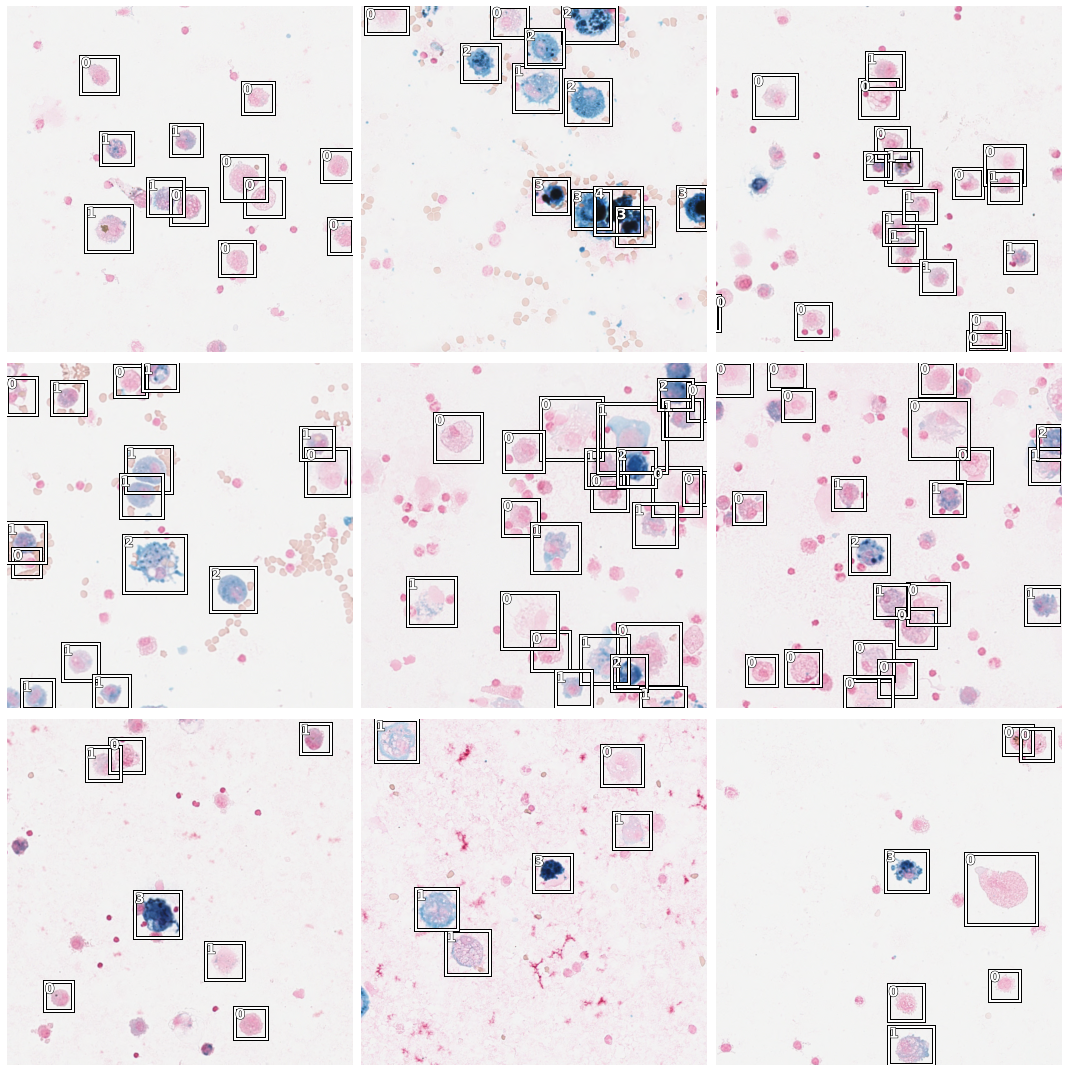

In [18]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [19]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7, 0.9, 1.25, 1.5])

In [20]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=5, sizes=[32], chs=128, final_bias=-4., n_conv=3)

In [21]:
model.load_state_dict(model_weights)

<All keys matched successfully>

In [22]:
voc = PascalVOCMetricByDistance(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]], radius=25)
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, partial(CSVLogger, append=True, filename=experiment_name)], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [23]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,AP-2,AP-3,AP-4,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


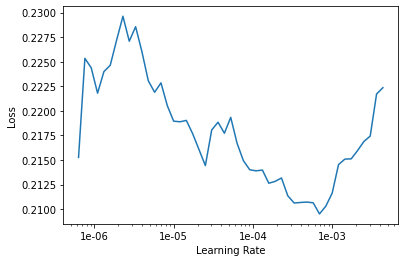

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,AP-2,AP-3,AP-4,time
0,0.219767,0.260972,0.669272,0.048137,0.212835,0.752699,0.746248,0.559276,0.561101,0.727037,26:10
1,0.200425,0.194872,0.756435,0.042812,0.152059,0.739557,0.764872,0.737770,0.686059,0.853919,30:12
2,0.178889,0.186859,0.761257,0.041152,0.145707,0.764530,0.771311,0.740233,0.682596,0.847617,28:27


In [26]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,AP-2,AP-3,AP-4,time
0,0.174143,0.192346,0.740804,0.042433,0.149913,0.707881,0.789279,0.709193,0.701311,0.796354,32:39
1,0.199461,0.245331,0.694962,0.049073,0.196259,0.731520,0.678056,0.555907,0.573729,0.935599,32:24
2,0.283843,0.365360,0.489098,0.066543,0.298817,0.656107,0.478451,0.480176,0.506030,0.324724,33:25


KeyboardInterrupt: 

In [ ]:
import pickle

stats = {"anchors": anchors,
         "mean": to_np(data.stats[0]),
         "std": to_np(data.stats[1]),
         "size": size,
         "n_classes": 6,
         "n_anchors": 5,
         "sizes": [32],
         "chs": 128,
         "encoder": "RN-18",
         "n_conv": 3,
         "level": 0,
         "model": get_model(learn.model).state_dict()
        }

torch.save(stats, "{}.p".format(experiment_name))

In [ ]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=20)